# Modeling the Müller-Brown Potential using Gaussian process regression

In [1]:
import numpy as np
import scipy.optimize as opt
import itertools
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

## Defining the Müller-Brown Potential

The Müller-Brown potential is a well-known model potential energy surface used in computational chemistry to study reaction dynamics and transition states. It is defined by a sum of four Gaussian-like terms, and its mathematical form is (for more details see [here](https://www.wolframcloud.com/objects/demonstrations/TrajectoriesOnTheMullerBrownPotentialEnergySurface-source.nb)): 

$ V(x,y) = \sum_{k=1}^4 A_k \mathrm{exp}\left( a_k \left( x - x_k^0 \right)^2 + b_k \left( x - x_k^0 \right) \left( y - y_k^0 \right) + c_k \left( y - y_k^0 \right)^2 \right) $.

First, we define the Müller-Brown potential as a Python function:

In [2]:
def mueller_brown_potential(x, y):
    """
    Compute the Müller-Brown potential energy function at position (x, y).

    Parameters:
    -----------
    x : float
        x-coordinate of the point.
    y : float
        y-coordinate of the point.

    Returns:
    --------
    value : float
        Potential energy at the given (x, y) position.
    """
    # Amplitude parameters
    A = [-200, -100, -170, 15]
    
    # Shape coefficients
    a = [-1, -1, -6.5, 0.7]
    b = [0, 0, 11, 0.6]
    c = [-10, -10, -6.5, 0.7]
    
    # Center coordinates of the minima
    x_0 = [1.0, 0.0, -0.5, -1.0]
    y_0 = [0.0, 0.5, 1.5, 1.0]

    v_xy = 0.0

    for k in range(4):
        dx = x - x_0[k]
        dy = y - y_0[k]
        # Scale the function by 0.1 to make visualization easier
        v_xy += 0.1 * A[k] * np.exp(a[k] * dx**2 + b[k] * dx * dy + c[k] * dy**2)

    return v_xy

## Generate Training Data

Next, we need to generate data points to train a Gaussian process regression model. The training data will be generated using the Müller-Brown Potential function and a range of x and y values.

In [4]:
# Generate a set of x and y values
x = np.arange(-1.8, 1.4, 0.05)
y = np.arange(-0.8, 2.4, 0.05)

# Pair x and y values
xy = [(i,j) for j in y for i in x]

# Calculate the function value for all pairs
v = [mueller_brown_potential(i,j) for j in y for i in x]

# Convert lists to numpy arrays
xy, v = np.array(xy), np.array(v)

# Create a rectangular grid from given one-dimensional arrays x and y
X, Y = np.meshgrid(x, y)

# Reshape v array so that we can plot our data on a 2D surface that is len(x) by len(y)
V = np.reshape(v, (len(x), -1))

# Print some statistics
print(f'V_min: {np.amin(V)},  V_max: {np.amax(V)}')

V_min: -14.66714784073065,  V_max: 1720.6621529992995


## Visualizing MB Potential: 3D Surface

We will now create a 3D plot of our data. To make the plot more readable, we will exclude the points that have extremely high energy.

In [5]:
fig = go.Figure(data=[go.Surface(z=V, x=X, y=Y, colorscale='rainbow', cmin=-15, cmax=9)])

# Add contour lines
fig.update_traces(contours_z=dict(show=True, project_z=True, width=1))

# Format the layout
fig.update_layout(
    title='Müller-Brown PES', 
    width=600, height=600,
    scene = dict(
        zaxis_title="V(x,y)",
        zaxis = dict(dtick=3, range=[-15, 15]),
        camera_eye = dict(x=-1.2, y=-1.2, z=1.0)
    )
)

fig.show()

## Visualizing MB Potential: Contour Plot

To allow for an easier visualization of the potential energy surface, we can generate a 2D contour surface.

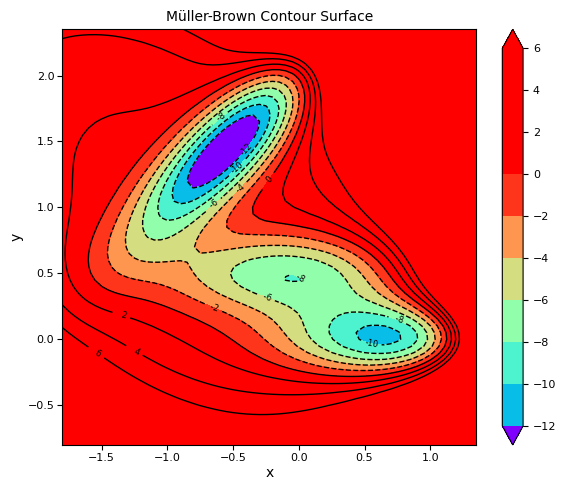

In [6]:
# Create the figure
fig = plt.figure(figsize=(6, 5))

# Define contour levels
levels = np.arange(-12, 8, 2)

# Contour lines
contour_lines = plt.contour(X, Y, V, levels=levels, colors='k', linewidths=1.0)
plt.clabel(contour_lines, inline=True, fmt='%3.0f', fontsize=6)

# Filled contours
contour_fill = plt.contourf(X, Y, V, levels=levels, cmap='rainbow', extend='both', vmin=-15, vmax=0)

# Axis labels and ticks
plt.xlabel("x", labelpad=2.5)
plt.ylabel("y", labelpad=2.5)
plt.tick_params(axis='both', pad=2, labelsize=8)

# Colorbar
cbar = plt.colorbar(contour_fill)
cbar.ax.tick_params(labelsize=8)

# Title
plt.title('Müller-Brown Contour Surface', fontsize=10)

# Layout
plt.tight_layout()
plt.show()

Generating some noisy training sample observations:

In [7]:
# Select every 2nd point for training
xy_train, v_train = xy[::2].copy(), v[::2].copy()
# Standard deviation of errors
sigma_n = 0.2
# Generate normally-distributed random observation errors
epsilon = np.random.normal(loc=0, scale=sigma_n, size=len(v_train))
# Compute noisy observations
v_train += epsilon

Generate test data points on which we want to generate predictions:

In [8]:
# Generate a set of x and y values
x_star = np.linspace(start=-1.8, stop=1.4, num=20)
y_star = np.linspace(start=-0.8, stop=2.4, num=20)

# Pair x and y values
xy_star = [(i,j) for j in y_star for i in x_star]

# Convert list to numpy array
xy_star = np.array(xy_star)

# Create a rectangular grid for plotting
X_star, Y_star = np.meshgrid(x_star, y_star)

n_star = len(xy_star)

## Kernel Function

A common choice of kernel function to compute covariances is the squared exponential (RBF): 

$ \text{Cov}\left( f(x),f(x') \right) = k(x,x') = \sigma_f^2 \exp \left(-\frac{1}{2\ell^2} \left( x - x' \right) ^2 \right) $, 

where $\ell$ (lenght scale) and $\sigma_f$ (signal variance) are hyperparameters.

In [9]:
# Define squared exponential kernel function
def kernel_function(X1, X2, length_scale=1.0, signal_variance=1.0):
    """
    Computes the squared exponential (RBF) kernel between two sets of points.
    
    Parameters:
    -----------
    X1 : np.ndarray, shape (n_1, 2)
        First set of input points.
    X2 : np.ndarray, shape (n_2, 2)
        Second set of input points.
    length_scale : float, default=1.0
        Length scale of the kernel (controls smoothness).
    signal_variance : float, default=1.0
        Signal variance (controls amplitude).
        
    Returns:
    --------
    kernel : np.ndarray, shape (n_1, n_2)
        Covariance matrix between X1 and X2.
    """    
    # The kernel formula
    squared_distance = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * X1 @ X2.T
    kernel = signal_variance**2 * np.exp(-0.5 * squared_distance / length_scale**2)
    
    return kernel


Set hyperparameters of the kernel:

In [10]:
length_scale = 0.1
signal_variance = 2.0

## Covariance Matrix

In [11]:
def compute_cov_matrix(xy_train, xy_test, length_scale, signal_variance, sigma_n):
    """
    Computing components of the covariance matrix of the joint distribution of train and test points, 
    where K = K(X,X), K_star = K(X*,X), and K_star_star = K(X*,X*).

    Parameters:
    -----------
    xy_train : np.ndarray, shape (n_train, 2)
        First input array.
    xy_test : np.ndarray, shape (n_test, 2)
        Second input array.
    length_scale : float
        Length scale for the kernel function.
    signal_variance : float
        Signal variance for the kernel function.

    Returns:
    --------
    C : np.ndarray, shape (n_train + n_test, n_train + n_test)
        Full covariance matrix C and its components K, K*, K**
    """
    n_train = len(xy_train)
    
    # K(X,X)
    K = kernel_function(xy_train, xy_train, length_scale, signal_variance)
    
    # Add the noise value 𝜎_𝑛 to K(X,X)
    K += sigma_n**2 * np.eye(n_train)
    
    # K(X*,X)
    K_star = kernel_function(xy_test, xy_train, length_scale, signal_variance)
    
    # K(X*,X*)
    K_star_star = kernel_function(xy_test, xy_test, length_scale, signal_variance)
    
    # Constructing the full covariance matrix from its components
    C = np.block([
        [K,      K_star.T   ],
        [K_star, K_star_star]
        ])
    
    return K, K_star, K_star_star, C

In [12]:
# Compute full covariance matrix
C = compute_cov_matrix(xy_train, xy_star, length_scale, signal_variance, sigma_n)

C[3].shape

(2448, 2448)

In [13]:
# Check if the covariance matrix C is symmetric
def is_symmetric(A, tol=1e-8):
    return np.allclose(A, A.T, atol=tol)

# Check if the covariance matrix C is positive semi-definite
def is_positive_semi_definite(A, tol=1e-8):
    eigvals = np.linalg.eigvalsh(A)
    return np.all(eigvals >= -tol)

print(is_symmetric(C[3]))
print(is_positive_semi_definite(C[3]))

True
True


## Prior Distribution

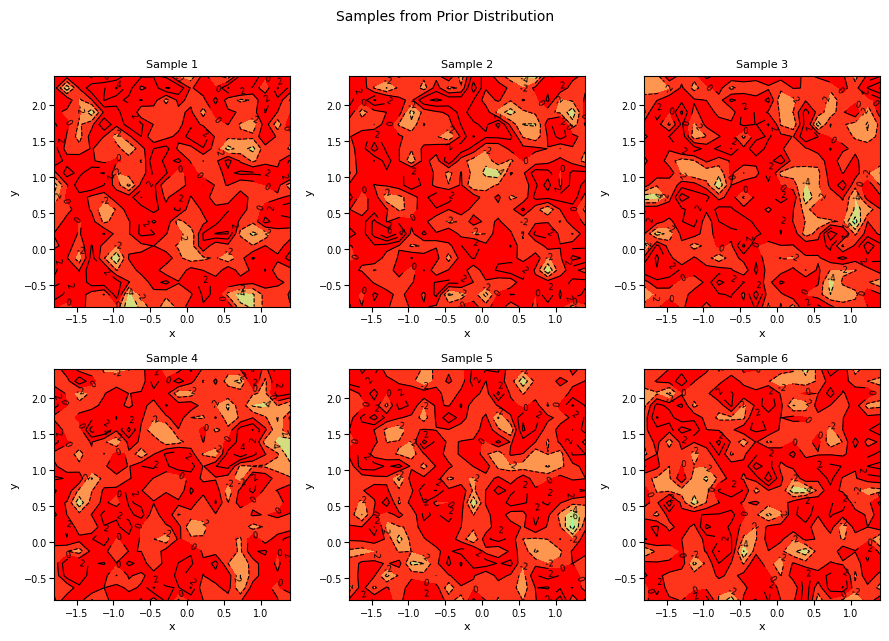

In [14]:
# Create 2x3 subplot grid
fig, axes = plt.subplots(2, 3, figsize=(9, 6.5))
axes = axes.flatten()  # Make it easier to loop over

for i in range(6):
    ax = axes[i]
    
    # Sample from prior
    f_star = np.random.multivariate_normal(mean=np.zeros(len(C[2])), cov=C[2])
    
    # Reshape f_star so that we can plot our data on a 2D surface
    F_star = np.reshape(f_star, (len(x_star), -1))
    
    # Plot contour lines
    contour_lines = ax.contour(X_star, Y_star, F_star, levels=levels, colors='k', linewidths=0.8)
    ax.clabel(contour_lines, inline=True, fmt='%3.0f', fontsize=6)
    
    # Filled contours
    contour_fill = ax.contourf(X_star, Y_star, F_star, levels=levels, cmap='rainbow', extend='both', vmin=-15, vmax=0)
    
    # Axis labels and ticks
    ax.set_xlabel("x", labelpad=2.5, fontsize=8)
    ax.set_ylabel("y", labelpad=2.5, fontsize=8)
    ax.tick_params(axis='both', pad=2, labelsize=7)
    ax.set_title(f'Sample {i+1}', fontsize=8)

fig.suptitle("Samples from Prior Distribution", fontsize=10)
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leave space for suptitle
plt.show()

## Conditional (Posterior) Distribution

In [15]:
# Define a function to compute parameters of the posterior distribution
def compute_gpr_parameters(C, y):
    """
    Compute the posterior mean and covariance of Gaussian Process.

    Parameters:
    -----------
    C : np.ndarray, shape (n_train + n_test, n_train + n_test)
        Full covariance matrix.
    y : np.ndarray, shape (n_train,)
        Training target values.

    Returns:
    --------
    f_bar_star : np.ndarray, shape (n_star,)
        Posterior mean of the predictions at the test inputs.
    cov_f_star : np.ndarray, shape (n_star, n_star)
        Posterior covariance of the predictions at the test inputs.
    """
    
    L = np.linalg.cholesky(C[0])
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))

    # Posterior mean
    f_bar_star = C[1] @ alpha
    
    v = np.linalg.solve(L, C[1].T)

    # Posterior covariance
    cov_f_star = C[2] - v.T @ v

    return f_bar_star, cov_f_star

In [16]:
# Compute posterior mean and covariance using the above function
f_bar_star, cov_f_star = compute_gpr_parameters(C, v_train)

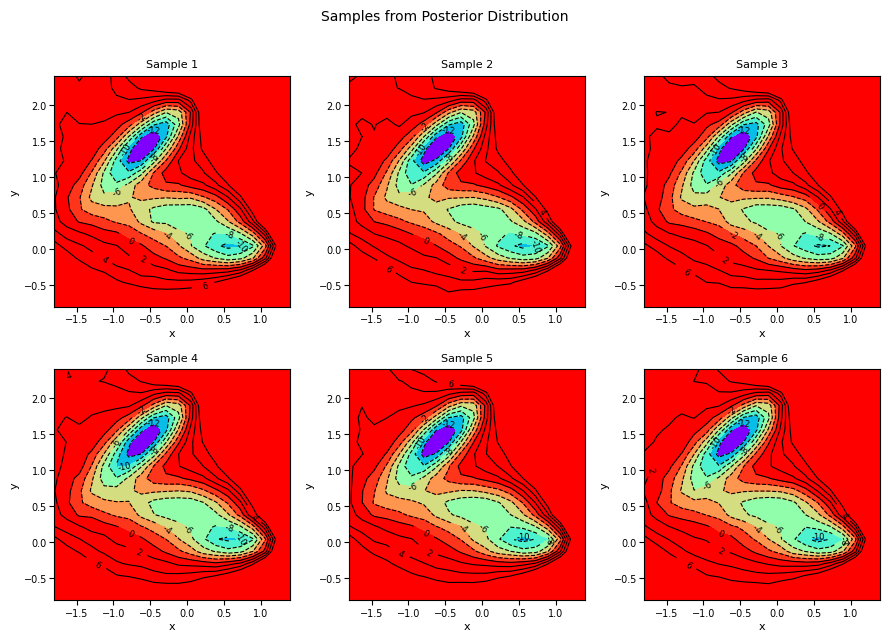

In [17]:
# Create 2x3 subplot grid
fig, axes = plt.subplots(2, 3, figsize=(9, 6.5))
axes = axes.flatten()  # Make it easier to loop over

for i in range(6):
    ax = axes[i]
    
    # Sample from posterior
    f_star = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star)
    
    # Reshape f_star so that we can plot our data on a 2D surface
    F_star = np.reshape(f_star, (len(x_star), -1))
    
    # Plot contour lines
    contour_lines = ax.contour(X_star, Y_star, F_star, levels=levels, colors='k', linewidths=0.8)
    ax.clabel(contour_lines, inline=True, fmt='%3.0f', fontsize=6)
    
    # Filled contours
    contour_fill = ax.contourf(X_star, Y_star, F_star, levels=levels, cmap='rainbow', extend='both', vmin=-15, vmax=0)
    
    # Axis labels and ticks
    ax.set_xlabel("x", labelpad=2.5, fontsize=8)
    ax.set_ylabel("y", labelpad=2.5, fontsize=8)
    ax.tick_params(axis='both', pad=2, labelsize=7)
    ax.set_title(f'Sample {i+1}', fontsize=8)

fig.suptitle("Samples from Posterior Distribution", fontsize=10)
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leave space for suptitle
plt.show()

In [ ]:
# Create 1x2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(9, 5))
axes = axes.flatten()  # Make it easier to loop over

# Plot the predicted surface as an average of n_samples from posterior
ax = axes[0]


# Samples from posterior
f_star = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star, size=20)

# Mean of samples
f_star = np.mean(f_star, axis=0)

# Reshape f_star so that we can plot our data on a 2D surface
F_star = np.reshape(f_star, (len(x_star), -1))

# Contour lines
contour_lines = ax.contour(X_star, Y_star, F_star, levels=levels, colors='k', linewidths=1.0)
ax.clabel(contour_lines, inline=True, fmt='%3.0f', fontsize=6)

# Filled contours
contour_fill = ax.contourf(X_star, Y_star, F_star, levels=levels, cmap='rainbow', extend='both', vmin=-15, vmax=0)

# Axis labels and ticks
ax.set_xlabel("x", labelpad=2.5, fontsize=8)
ax.set_ylabel("y", labelpad=2.5, fontsize=8)
ax.tick_params(axis='both', pad=2, labelsize=7)
ax.set_title(f'Predicted Surface', fontsize=8)

# Plot the true potential energy surface
ax = axes[1]

# Plot contour lines
contour_lines = ax.contour(X, Y, V, levels=levels, colors='k', linewidths=1.0)
ax.clabel(contour_lines, inline=True, fmt='%3.0f', fontsize=6)

# Filled contours
contour_fill = ax.contourf(X, Y, V, levels=levels, cmap='rainbow', extend='both', vmin=-15, vmax=0)

# Axis labels and ticks
ax.set_xlabel("x", labelpad=2.5, fontsize=8)
ax.set_ylabel("y", labelpad=2.5, fontsize=8)
ax.tick_params(axis='both', pad=2, labelsize=7)
ax.set_title(f'True Surface', fontsize=8)

fig.suptitle("Predicted vs True Function", fontsize=10)
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leave space for suptitle
plt.show()

## Optimizing the Hyperparameters

In [18]:
# Negative Log Marginal Likelihood
def log_marginal_likelihood(params, train_points, train_labels):
    """
    Compute the negative log marginal likelihood of Gaussian Process.

    Parameters:
    -----------
    params : tuple of floats
        Hyperparameters: length_scale, signal_variance, sigma_n.
    train_points : np.ndarray, shape (n_train, 2)
        Training input coordinates.
    train_labels : np.ndarray, shape (n_train,)
        Training target values.

    Returns:
    --------
    negative_log_likelihood : float
        The negative log marginal likelihood of the training data under the current hyperparameters.
    """
    length_scale, signal_variance, sigma_n = params
    
    # Compute covariance matrix K
    K = kernel_function(train_points, train_points, length_scale, signal_variance)
    K += sigma_n**2 * np.eye(len(train_points))

    try:
        L = np.linalg.cholesky(K)
    except np.linalg.LinAlgError:
        return np.inf

    # Solve K^−1.y using the Cholesky decomposition
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, train_labels))
    
    # Compute the log determinant of K using its Cholesky factor
    log_det_K = 2 * np.sum(np.log(np.diag(L)))
    
    # Compute negative log marginal likelihood 
    NLL = 0.5 * ( train_labels.T @ alpha + log_det_K + len(train_labels) * np.log(2 * np.pi) )
    
    return NLL

In [19]:
# Initial guess for (length_scale, signal_variance, sigma_n)
initial_params = (1.0, 1.0, 0.5)

# Optimize hyperparameters
result = opt.minimize(
    log_marginal_likelihood,
    initial_params,
    args=(xy_train, v_train),
    bounds=[(0.01, 10.0), (0.01, 10.0), (0.01, 5.0)], 
    method="L-BFGS-B",
    options={'disp': True}
    )

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.05711D+06    |proj g|=  9.00000D+00

At iterate    1    f=  6.50223D+04    |proj g|=  9.99000D+00

At iterate    2    f=  1.54383D+04    |proj g|=  1.90070D-01

At iterate    3    f=  1.54382D+04    |proj g|=  1.89344D-01

At iterate    4    f=  1.54382D+04    |proj g|=  7.56700D-02

At iterate    5    f=  1.54382D+04    |proj g|=  3.63798D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5     15      7     0     2   

In [20]:
# Get optimization results
print(f'Optimization {"Successful" if result.success else "Failed"}!')

opt_length_scale, opt_signal_variance, opt_sigma_n = result.x
print("Optimal length_scale:", opt_length_scale)
print("Optimal signal_variance:", opt_signal_variance)
print("Optimal sigma_n:", opt_sigma_n)

Optimization Successful!
Optimal length_scale: 0.19929992997081933
Optimal signal_variance: 10.0
Optimal sigma_n: 5.0


## Building a GPR Model using Energies and Gradients

We start by defining derivatives of the Müller-Brown function with respect to $x$ and $y$:

$ \frac{\partial V}{\partial x}  = \sum_{k=1}^4 A_k \mathrm{exp}\left( a_k \left(x - x_k^0\right)^2 + b_k \left(x - x_k^0\right) \left(y - y_k^0\right) + c_k \left(y - y_k^0\right)^2 \right) \left( 2a_k \left(x - x_k^0\right) + b_k \left(y - y_k^0\right) \right) $,

$ \frac{\partial V}{\partial y}  = \sum_{k=1}^4 A_k \mathrm{exp}\left( a_k \left(x - x_k^0\right)^2 + b_k \left(x - x_k^0\right) \left(y - y_k^0\right) + c_k \left(y - y_k^0\right)^2 \right) \left( b_k \left(x - x_k^0\right) + 2 c_k \left(y - y_k^0\right) \right) $.


In [21]:
def mueller_brown_potential_gradient(x, y):
    """
    Compute the partial derivatives of Müller-Brown potential energy function.

    Parameters:
    -----------
    x : float
        x-coordinate of the point.
    y : float
        y-coordinate of the point.

    Returns:
    --------
    value : float
        Partial derivatives of potential energy at the given (x, y) position.
    """
    # Amplitude parameters
    A = [-200, -100, -170, 15]
    
    # Shape coefficients
    a = [-1, -1, -6.5, 0.7]
    b = [0, 0, 11, 0.6]
    c = [-10, -10, -6.5, 0.7]
    
    # Center coordinates of the minima
    x_0 = [1.0, 0.0, -0.5, -1.0]
    y_0 = [0.0, 0.5, 1.5, 1.0]

    dv_x, dv_y = 0.0, 0.0

    for k in range(4):
        dx = x - x_0[k]
        dy = y - y_0[k]
        # Scale the function by 0.1 to make visualization easier
        dv_x += 0.1 * A[k] * np.exp(a[k] * dx**2 + b[k] * dx * dy + c[k] * dy**2) * (2 * a[k] * dx + b[k] * dy)
        dv_y += 0.1 * A[k] * np.exp(a[k] * dx**2 + b[k] * dx * dy + c[k] * dy**2) * (b[k] * dx + 2 * c[k] * dy)

    return dv_x, dv_y

Let $\mathrm{\textbf{y}_{ext}}$ be an extended observation set that also includes a set of derivative observations, 

$ \mathrm{\textbf{y}}_\mathrm{ext}=  \left[y_1,\cdots,y_n,\frac{\partial f(\textbf{x}_1)}{\partial x},\cdots,\frac{\partial f(\textbf{x}_n)}{\partial x},\frac{\partial f(\textbf{x}_1)}{\partial y},\cdots,\frac{\partial f(\textbf{x}_n)}{\partial y}\right]^{\top} $.

In [22]:
# Calculate the derivative value for all pairs
dv = [mueller_brown_potential_gradient(i,j) for j in y for i in x]
# Convert list to numpy array
dv = np.array(dv)
# Slice and reshape dv array so that we can plot derivatives on 2D surfaces
dV_x = np.reshape(dv[:, 0], (len(x), -1))
dV_y = np.reshape(dv[:, 1], (len(y), -1))

# Select every 2nd point for training
dv_train = dv[::2].copy()
# Standard deviation of errors
sigma_d = 0.1
# Generate normally-distributed random observation errors
epsilon = np.random.normal(loc=0, scale=sigma_d, size=dv_train.shape)
# Compute noisy derivative observations
dv_train += epsilon

dv_x = dv_train[:, 0]
dv_y = dv_train[:, 1]
y_ext = np.concatenate((v_train, dv_x, dv_y))

y_ext.shape

(6144,)

Let us visualize the Müller-Brown potential energy surface along with its gradient surfaces:

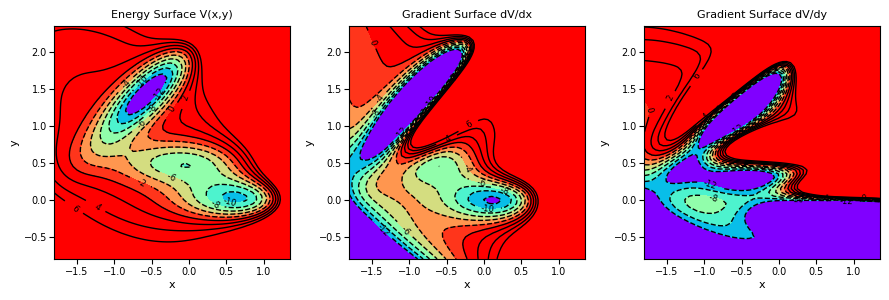

In [23]:
# Create 1x3 subplot grid
fig, axes = plt.subplots(1, 3, figsize=(9, 3.2))
axes = axes.flatten()  # Make it easier to loop over

# Plot the potential energy surface
ax = axes[0]

# Plot contour lines
contour_lines = ax.contour(X, Y, V, levels=levels, colors='k', linewidths=1.0)
ax.clabel(contour_lines, inline=True, fmt='%3.0f', fontsize=6)

# Filled contours
contour_fill = ax.contourf(X, Y, V, levels=levels, cmap='rainbow', extend='both', vmin=-15, vmax=0)

# Axis labels and ticks
ax.set_xlabel("x", labelpad=2.5, fontsize=8)
ax.set_ylabel("y", labelpad=2.5, fontsize=8)
ax.tick_params(axis='both', pad=2, labelsize=7)
ax.set_title(f'Energy Surface V(x,y)', fontsize=8)

# Plot the dx surface
ax = axes[1]

# Plot contour lines
contour_lines = ax.contour(X, Y, dV_x, levels=levels, colors='k', linewidths=1.0)
ax.clabel(contour_lines, inline=True, fmt='%3.0f', fontsize=6)

# Filled contours
contour_fill = ax.contourf(X, Y, dV_x, levels=levels, cmap='rainbow', extend='both', vmin=-15, vmax=0)

# Axis labels and ticks
ax.set_xlabel("x", labelpad=2.5, fontsize=8)
ax.set_ylabel("y", labelpad=2.5, fontsize=8)
ax.tick_params(axis='both', pad=2, labelsize=7)
ax.set_title(f'Gradient Surface dV/dx', fontsize=8)

# Plot the dy surface
ax = axes[2]

# Plot contour lines
contour_lines = ax.contour(X, Y, dV_y, levels=levels, colors='k', linewidths=1.0)
ax.clabel(contour_lines, inline=True, fmt='%3.0f', fontsize=6)

# Filled contours
contour_fill = ax.contourf(X, Y, dV_y, levels=levels, cmap='rainbow', extend='both', vmin=-15, vmax=0)

# Axis labels and ticks
ax.set_xlabel("x", labelpad=2.5, fontsize=8)
ax.set_ylabel("y", labelpad=2.5, fontsize=8)
ax.tick_params(axis='both', pad=2, labelsize=7)
ax.set_title(f'Gradient Surface dV/dy', fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leave space for suptitle
plt.show()

In [24]:
def kernel_derivative(X1, X2, length_scale=1.0, signal_variance=1.0):
    """
    Computes the kernel matrix including function values and partial derivatives.

    Parameters:
    -----------
    X1 : np.ndarray, shape (n_1, 2)
        First input array.
    X2 : np.ndarray, shape (n_2, 2)
        Second input array.
    length_scale : float, default=1.0
        Length scale for the kernel function.
    signal_variance : float, default=1.0
        Signal variance for the kernel function.

    Returns:
    --------
    K_full : np.ndarray, shape (3*n_1, 3*n_2)
        Combined kernel block matrix with values and derivatives.
    """
    # k(x,x')
    K = kernel_function(X1, X2, length_scale, signal_variance)

    # (x_i - x'_j) / l²
    dx = np.subtract.outer(X1[:, 0], X2[:, 0]) / length_scale**2
    # (y_i - y'_j) / l²
    dy = np.subtract.outer(X1[:, 1], X2[:, 1]) / length_scale**2
    
    # Cov(f,f') = k(x,x')
    K_f_f = K

    # Cov(∂f/∂x,f') = ∂k(x,x')/∂x
    K_dx_f = - dx * K
    
    # Cov(f,∂f'/∂x') = ∂k(x,x')/∂x' = - Cov(∂f/∂x,f')
    K_f_dx = - K_dx_f
    
    # Cov(∂f/∂y,f') = ∂k(x,x')/∂y
    K_dy_f = - dy * K
    
    # Cov(f,∂f'/∂y') = ∂k(x,x')/∂y' = - Cov(∂f/∂y,f')
    K_f_dy = - K_dy_f

    # Cov(∂f/∂x,∂f'/∂x') = ∂²k/∂x∂x'
    K_dx_dx = (1 / length_scale**2 - dx**2) * K
    
    # Cov(∂f/∂y,∂f'/∂y') = ∂²k/∂y∂y'
    K_dy_dy = (1 / length_scale**2 - dy**2) * K
    
    # Cov(∂f/∂y,∂f'/∂x') = ∂²k/∂y∂x'
    K_dy_dx = - dx * dy * K
    
    # Cov(∂f/∂x,∂f'/∂y') = ∂²k/∂x∂y' = Cov(∂f/∂y,∂f'/∂x')
    K_dx_dy = K_dy_dx

    # Assemble full matrix
    K_full = np.block([
        [ K_f_f,   K_f_dx,   K_f_dy  ],
        [ K_dx_f,  K_dx_dx,  K_dx_dy ],
        [ K_dy_f,  K_dy_dx,  K_dy_dy ]
    ])

    return K_full

In [25]:
def compute_ext_cov_matrix(xy_train, xy_test, length_scale, signal_variance, sigma_n, sigma_d):
    """
    Computing components of the covariance matrix of the joint distribution of train and test points, 
    where K = K(X,X), K_star = K(X*,X), and K_star_star = K(X*,X*).

    Parameters:
    -----------
    xy_train : np.ndarray, shape (n_train, 2)
        First input array.
    xy_test : np.ndarray, shape (n_test, 2)
        Second input array.
    length_scale : float
        Length scale for the kernel function.
    signal_variance : float
        Signal variance for the kernel function.

    Returns:
    --------
    C : np.ndarray, shape (n_train + n_test, n_train + n_test)
        Full covariance matrix C and its components K, K*, K**
    """
    n_train = len(xy_train)
    
    # K(X,X)
    K = kernel_derivative(xy_train, xy_train, length_scale, signal_variance)
    
    # Add the noise value 𝜎_𝑛 to the upper left block of K(X,X)
    K[:n_train, :n_train] += (sigma_n**2) * np.eye(n_train)
    # Add the noise value 𝜎_d to the lower right block of K(X,X)
    K[n_train:, n_train:] += (sigma_d**2) * np.eye(n_train * 2)
    
    # K(X*,X)
    K_star = kernel_derivative(xy_test, xy_train, length_scale, signal_variance)
    
    # K(X*,X*)
    K_star_star = kernel_derivative(xy_test, xy_test, length_scale, signal_variance)
    
    # Constructing the full covariance matrix from its components
    C = np.block([
        [K,      K_star.T   ],
        [K_star, K_star_star]
        ])
    
    return K, K_star, K_star_star, C

In [26]:
# Compute full covariance matrix
C_ext = compute_ext_cov_matrix(xy_train, xy_star, length_scale, signal_variance, sigma_n, sigma_d=sigma_d)

print(C_ext[3].shape)
print(is_symmetric(C_ext[3]))
print(is_positive_semi_definite(C_ext[3]))

(7344, 7344)
True
True


In [27]:
# Compute posterior mean and covariance using the above function
mean, cov = compute_gpr_parameters(C_ext, y_ext)

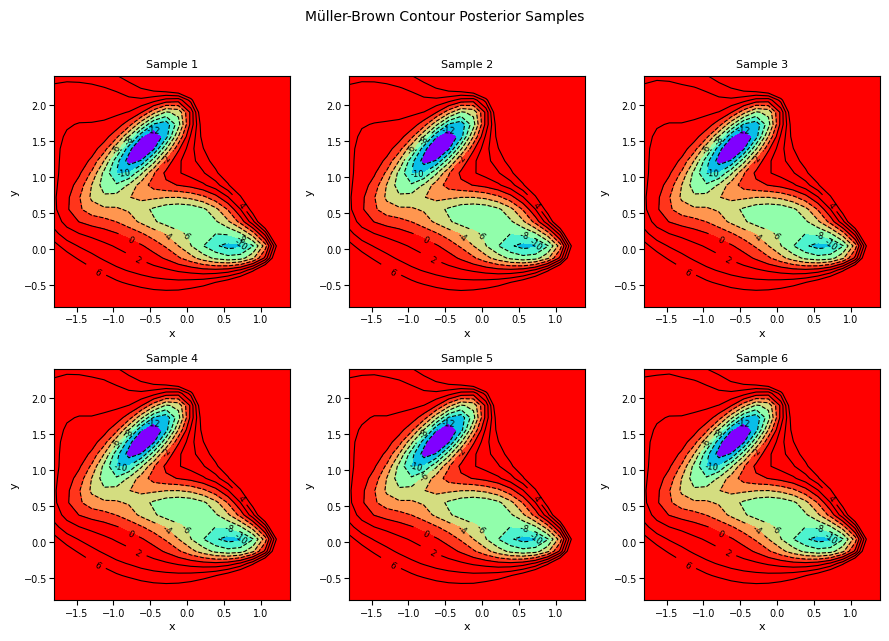

In [28]:
# Create 2x3 subplot grid
fig, axes = plt.subplots(2, 3, figsize=(9, 6.5))
axes = axes.flatten()  # Make it easier to loop over

for i in range(6):
    ax = axes[i]
    
    # Sample from posterior
    f_star = np.random.multivariate_normal(mean=mean[:n_star].squeeze(), cov=cov[:n_star, :n_star])
    
    # Reshape f_star so that we can plot our data on a 2D surface
    F_star = np.reshape(f_star, (len(x_star), -1))
    
    # Plot contour lines
    contour_lines = ax.contour(X_star, Y_star, F_star, levels=levels, colors='k', linewidths=0.8)
    ax.clabel(contour_lines, inline=True, fmt='%3.0f', fontsize=6)
    
    # Filled contours
    contour_fill = ax.contourf(X_star, Y_star, F_star, levels=levels, cmap='rainbow', extend='both', vmin=-15, vmax=0)
    
    # Axis labels and ticks
    ax.set_xlabel("x", labelpad=2.5, fontsize=8)
    ax.set_ylabel("y", labelpad=2.5, fontsize=8)
    ax.tick_params(axis='both', pad=2, labelsize=7)
    ax.set_title(f'Sample {i+1}', fontsize=8)

fig.suptitle("Müller-Brown Contour Posterior Samples", fontsize=10)
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leave space for suptitle
plt.show()

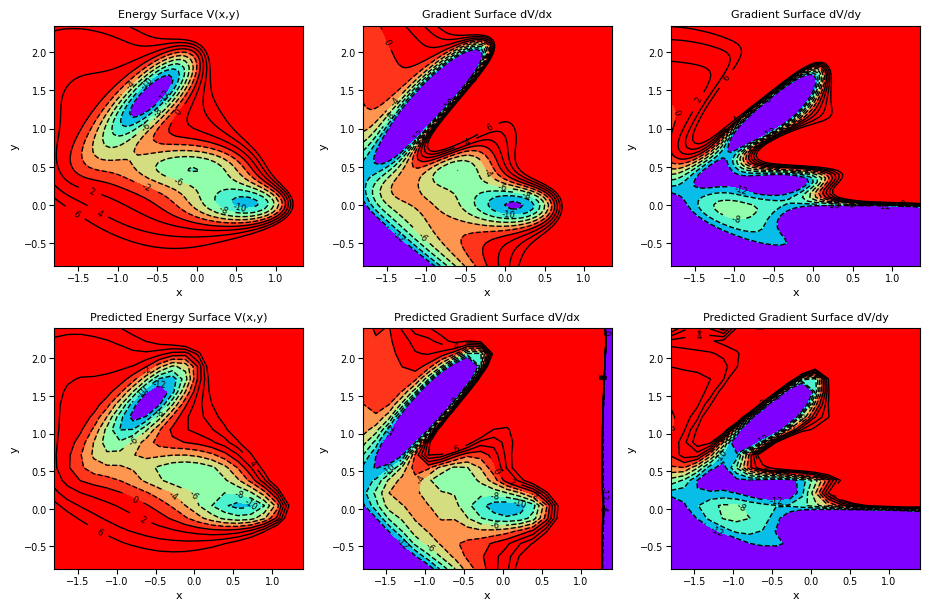

In [29]:
# Create 2x3 subplot grid
fig, axes = plt.subplots(2, 3, figsize=(9.4, 6.4))
axes = axes.flatten()  # Make it easier to loop over

# --- Plot true potential energy surface ---
ax = axes[0]
# Plot contour lines
contour_lines = ax.contour(X, Y, V, levels=levels, colors='k', linewidths=1.0)
ax.clabel(contour_lines, inline=True, fmt='%3.0f', fontsize=6)
# Filled contours
contour_fill = ax.contourf(X, Y, V, levels=levels, cmap='rainbow', extend='both', vmin=-15, vmax=0)
# Axis labels and ticks
ax.set_xlabel("x", labelpad=2.5, fontsize=8)
ax.set_ylabel("y", labelpad=2.5, fontsize=8)
ax.tick_params(axis='both', pad=2, labelsize=7)
ax.set_title(f'Energy Surface V(x,y)', fontsize=8)

# --- Plot true dx surface ---
ax = axes[1]
# Plot contour lines
contour_lines = ax.contour(X, Y, dV_x, levels=levels, colors='k', linewidths=1.0)
ax.clabel(contour_lines, inline=True, fmt='%3.0f', fontsize=6)
# Filled contours
contour_fill = ax.contourf(X, Y, dV_x, levels=levels, cmap='rainbow', extend='both', vmin=-15, vmax=0)
# Axis labels and ticks
ax.set_xlabel("x", labelpad=2.5, fontsize=8)
ax.set_ylabel("y", labelpad=2.5, fontsize=8)
ax.tick_params(axis='both', pad=2, labelsize=7)
ax.set_title(f'Gradient Surface dV/dx', fontsize=8)

# --- Plot true dy surface ---
ax = axes[2]
# Plot contour lines
contour_lines = ax.contour(X, Y, dV_y, levels=levels, colors='k', linewidths=1.0)
ax.clabel(contour_lines, inline=True, fmt='%3.0f', fontsize=6)
# Filled contours
contour_fill = ax.contourf(X, Y, dV_y, levels=levels, cmap='rainbow', extend='both', vmin=-15, vmax=0)
# Axis labels and ticks
ax.set_xlabel("x", labelpad=2.5, fontsize=8)
ax.set_ylabel("y", labelpad=2.5, fontsize=8)
ax.tick_params(axis='both', pad=2, labelsize=7)
ax.set_title(f'Gradient Surface dV/dy', fontsize=8)

# ---- Generate samples from the posterior ----
f_star = np.random.multivariate_normal(mean=mean[:n_star].squeeze(), cov=cov[:n_star, :n_star], size=20)
f_star = np.mean(f_star, axis=0)
F_star = np.reshape(f_star, (len(x_star), -1))

dfx_star = np.random.multivariate_normal(mean=mean[n_star:n_star*2].squeeze(), cov=cov[n_star:n_star*2, n_star:n_star*2], size=20)
dfx_star = np.mean(dfx_star, axis=0)
dFx_star = np.reshape(dfx_star, (len(x_star), -1))

dfy_star = np.random.multivariate_normal(mean=mean[n_star*2:].squeeze(), cov=cov[n_star*2:, n_star*2:], size=20)
dfy_star = np.mean(dfy_star, axis=0)
dFy_star = np.reshape(dfy_star, (len(x_star), -1))

# --- Plot predicted potential energy surface ---
ax = axes[3]
# Contour lines
contour_lines = ax.contour(X_star, Y_star, F_star, levels=levels, colors='k', linewidths=1.0)
ax.clabel(contour_lines, inline=True, fmt='%3.0f', fontsize=6)
# Filled contours
contour_fill = ax.contourf(X_star, Y_star, F_star, levels=levels, cmap='rainbow', extend='both', vmin=-15, vmax=0)
# Axis labels and ticks
ax.set_xlabel("x", labelpad=2.5, fontsize=8)
ax.set_ylabel("y", labelpad=2.5, fontsize=8)
ax.tick_params(axis='both', pad=2, labelsize=7)
ax.set_title(f'Predicted Energy Surface V(x,y)', fontsize=8)

# --- Plot predicted dx surface ---
ax = axes[4]
# Contour lines
contour_lines = ax.contour(X_star, Y_star, dFx_star, levels=levels, colors='k', linewidths=1.0)
ax.clabel(contour_lines, inline=True, fmt='%3.0f', fontsize=6)
# Filled contours
contour_fill = ax.contourf(X_star, Y_star, dFx_star, levels=levels, cmap='rainbow', extend='both', vmin=-15, vmax=0)
# Axis labels and ticks
ax.set_xlabel("x", labelpad=2.5, fontsize=8)
ax.set_ylabel("y", labelpad=2.5, fontsize=8)
ax.tick_params(axis='both', pad=2, labelsize=7)
ax.set_title(f'Predicted Gradient Surface dV/dx', fontsize=8)

# --- Plot predicted dy surface ---
ax = axes[5]
# Contour lines
contour_lines = ax.contour(X_star, Y_star, dFy_star, levels=levels, colors='k', linewidths=1.0)
ax.clabel(contour_lines, inline=True, fmt='%3.0f', fontsize=6)
# Filled contours
contour_fill = ax.contourf(X_star, Y_star, dFy_star, levels=levels, cmap='rainbow', extend='both', vmin=-15, vmax=0)
# Axis labels and ticks
ax.set_xlabel("x", labelpad=2.5, fontsize=8)
ax.set_ylabel("y", labelpad=2.5, fontsize=8)
ax.tick_params(axis='both', pad=2, labelsize=7)
ax.set_title(f'Predicted Gradient Surface dV/dy', fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leave space for suptitle
plt.show()